# PyMC-Marketing: MMM

This notebook will showcase an example of how to use the Bayesian Media Mix Models (MMMs) in PyMC. We will follow the [MMM Example Notebook](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_example.html) available in the official PyMC-Marketing documentation. However, we will use an already created dataset instead of creating it like in the official notebook.

## Table of contents

1. [Introduction](#introduction)
2. [Model Specification](#model_specification)
3. [Import libraries](#import_libraries)
4. [Load dataset](#load_dataset)
5. [Preprocess data](#preprocess_data)
6. [Model fitting](#model_fitting)

## Introduction<a name="introduction"></a>

[Marketing Mix Modeling (MMM)](https://en.wikipedia.org/wiki/Marketing_mix_modeling) is a powerful statistical approach that helps organizations understand the impact of various marketing channels on a target metric, such as sales or conversions. By quantifying the effectiveness of different marketing activities, MMM enables data-driven decision-making in allocating resources and optimizing marketing strategies.

MMM models take into account various marketing channels and other external factors, such as seasonality and economic indicators, to quantify their contributions to the target metric. The models tipically employ regression-based techniques to establish relationships between marketing spend and the target metric, while accounting for potential cofounders and biases.

[PyMC](https://www.pymc.io/welcome.html) is a popular Bayesian probabilistic programming library for Python that enables users to create complex statistical models using a flexible and intuitive syntax. With PyMC, it is possible to incorporate uncertainties inherent in marketing data and obtain robust results that account for potential cofounders and biases.

By using [PyMC-Marketing](https://www.pymc-marketing.io/en/latest/) for MMM, marketers can leverage the power of Bayesian inference to estimate the effects of marketing channels with greater precision. Some of the advantages of using Bayesian methods in MMM include:

* **Handling uncertainty:** Bayesian methods provide a natural way to incorporate uncertainty in the data and model, resulting in posterior distributions of model parameters that represent the range of possible values given the data.
* **Flexibility:** PyMC allowsfor the creation of complex, customized models that can account for non-linear relationships, interactions, and hierarchical structures in the data.
* **Prior knowledge integration:** Bayesian methods enable the integration of prior knowledge or beliefs about model parameters, which can improve the estimation process, especially when data is scarce or noisy.
* **Model comparison:** PyMC offers tools to compare different models using Bayesian model comparison techniques, such as the Bayes factor or the Widely Applicable Information Criterion (WAIC), to identify the most suitable model for the data.

In the following notebook we will see an example of use case of PyMC-Marketing's MMM models and how we can leverage the power of Bayesian inference for Marketing purposes.

## Model Specification<a name="model_specification"></a>

`pymc-marketing` library provides an API for a Bayesian MMM model following the famous paper [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/). Concretely, given a time series target variable $y_{t}$ (e.g. sales or conversions), media variables $x_{m,t}$ (e.g. impressions, clicks or spends) and a set of control variables (e.g. holidays, special events), the model has the following form:

$$
y_{t} = \alpha + \sum_{m=1}^{M} \beta_{m}f(x_{m,t}) + \sum_{c=1}^{C}\gamma_{c}z_{c,t} + \varepsilon_{t},
$$

where $\alpha$ is the intercept, $f$ is a media transformation function and $\varepsilon_{t}$ is the error term which it is assumed to be normally distributed. The function $f$ encodes the contribution of media on the target variable. Typically, two types of transformations are considered:

* **Adstock (carry-over):** The effect of spend on sales is not instantaneous but accumulates over time. This type of carry-over effect is modeled by transforming the time series of media spend in one channel through the *adstock* function:

$$
adstock(x_{t-L+1,m, \cdots, x_{t,m}; \omega_{m}, L}) = \frac{\sum_{l=0}^{L-1}\omega_{m}(l)x_{t-l,m}}{\sum_{l=0}^{L-1}\omega_{m}(l)}
$$

&emsp;&emsp;&emsp;where $\omega_{m}$ is a nonnegative weight function and $L$ is the maximum duration of carryover effect assumed for a channel. We can use different functional forms for the weight function $\omega_{m}$ such as the *geometric decay* $\omega^{g}$:

$$
\omega_{m}^{g}(l; \alpha_{m}) = \alpha_{m}^{l}, \hspace{1cm} l= 0, \cdots, L, \hspace{0.5cm} 0 < \alpha_{m} < 1
$$

&emsp;&emsp;&emsp;or the *delayed adstock* function $\omega^{d}$:

$$
\omega_{m}^{d}(l; \alpha_{m}, \theta_{m}) = \alpha_{m}^{(l-\theta_{m})^{2}}, \hspace{1cm} l=0, \cdots, L-1, \hspace{0.5cm} 0<\alpha_{m} < 1, \hspace{0.5cm} 0\leq \theta_{m} \leq L-1
$$

&emsp;&emsp;&emsp;where $\theta_{m}$ is the delay of the peak effect of the advertising on channel $m$.

* **Saturation:** There is also a saturation effect on media spend. That is, the effect of spend on sales is not linear but saturates at some point. The curvature function to model the saturation of the media spend is the $\beta$-Hill function:

$$
\beta_{m}Hill_{m}(x_{t,m}) = \beta_{m} - \frac{\kappa_{m}^{S{m}\beta_{m}}}{x_{t,m}^{S_{m}} + \kappa_{m}^{S_{m}}}
$$

&emsp;&emsp;&emsp;where $\beta_{m}$ is the coefficient of the $m$-th media channel, $S_{m} > 0$ is the shape parameter which is also referred to as *slope*, and $\kappa_{m} > 0$ is the half saturation point.

## Import libraries<a name="import_libraries"></a>

In [1]:
import arviz as az 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pymc_marketing.mmm.preprocessing import MaxAbsScaleChannels, MaxAbsScaleTarget, StandardizeControls
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load dataset

The dataset that is being used in this example notebook is retrieved from [this GitHub repo](https://github.com/sibylhe/mmm_stan). I'm not sure if the data is real or synthetic, but it looks realistic enough for our example.

In [2]:
data = pd.read_csv("datasets/dataset_mmm.csv")

data.head()

wk_strt_dt  yr_nbr  qtr_nbr  prd  wk_nbr  wk_in_yr_nbr   mdip_dm   
0  2014-08-03    2014        3    7       1            27   4863885  \
1  2014-08-10    2014        3    7       2            28  20887502   
2  2014-08-17    2014        3    7       3            29  11097724   
3  2014-08-24    2014        3    7       4            30   1023446   
4  2014-08-31    2014        3    8       1            31  21109811   

   mdip_inst  mdip_nsp  mdip_auddig  ...  seas_prd_12  seas_week_40   
0   29087520   2421933       692315  ...            0             0  \
1    8345120   3984494       475810  ...            0             0   
2   17276800   1846832       784732  ...            0             0   
3   18468480   2394834      1032301  ...            0             0   
4   26659920   3312008       400456  ...            0             0   

   seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
0             0             0             0             0             0  \
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   seas_week_46  seas_week_47  seas_week_48  
0             0             0             0  
1             0             0             0  
2             0             0             0  
3             0             0             0  
4             0             0             0  

[5 rows x 80 columns]

As we can see, we have each media channel spend, as well as control variables such as holiday or seasonality variables. Our target variable will be the `sales` column.

Let's take a quick look at the media data. This data contains four years of records of data at a weekly level. In our example, we will be using all the media channels for media spending data, and holiday and seasonal information for control variables.

In [3]:
# Media data
media_columns = [col for col in data.columns if 'mdsp_' in col]
media_data = data[media_columns]

# Control variables
holiday_columns = [col for col in data.columns if 'hldy_' in col]
holiday_data = data[holiday_columns]
seasonal_columns = [col for col in data.columns if 'seas_' in col]
seasonal_data = data[seasonal_columns]

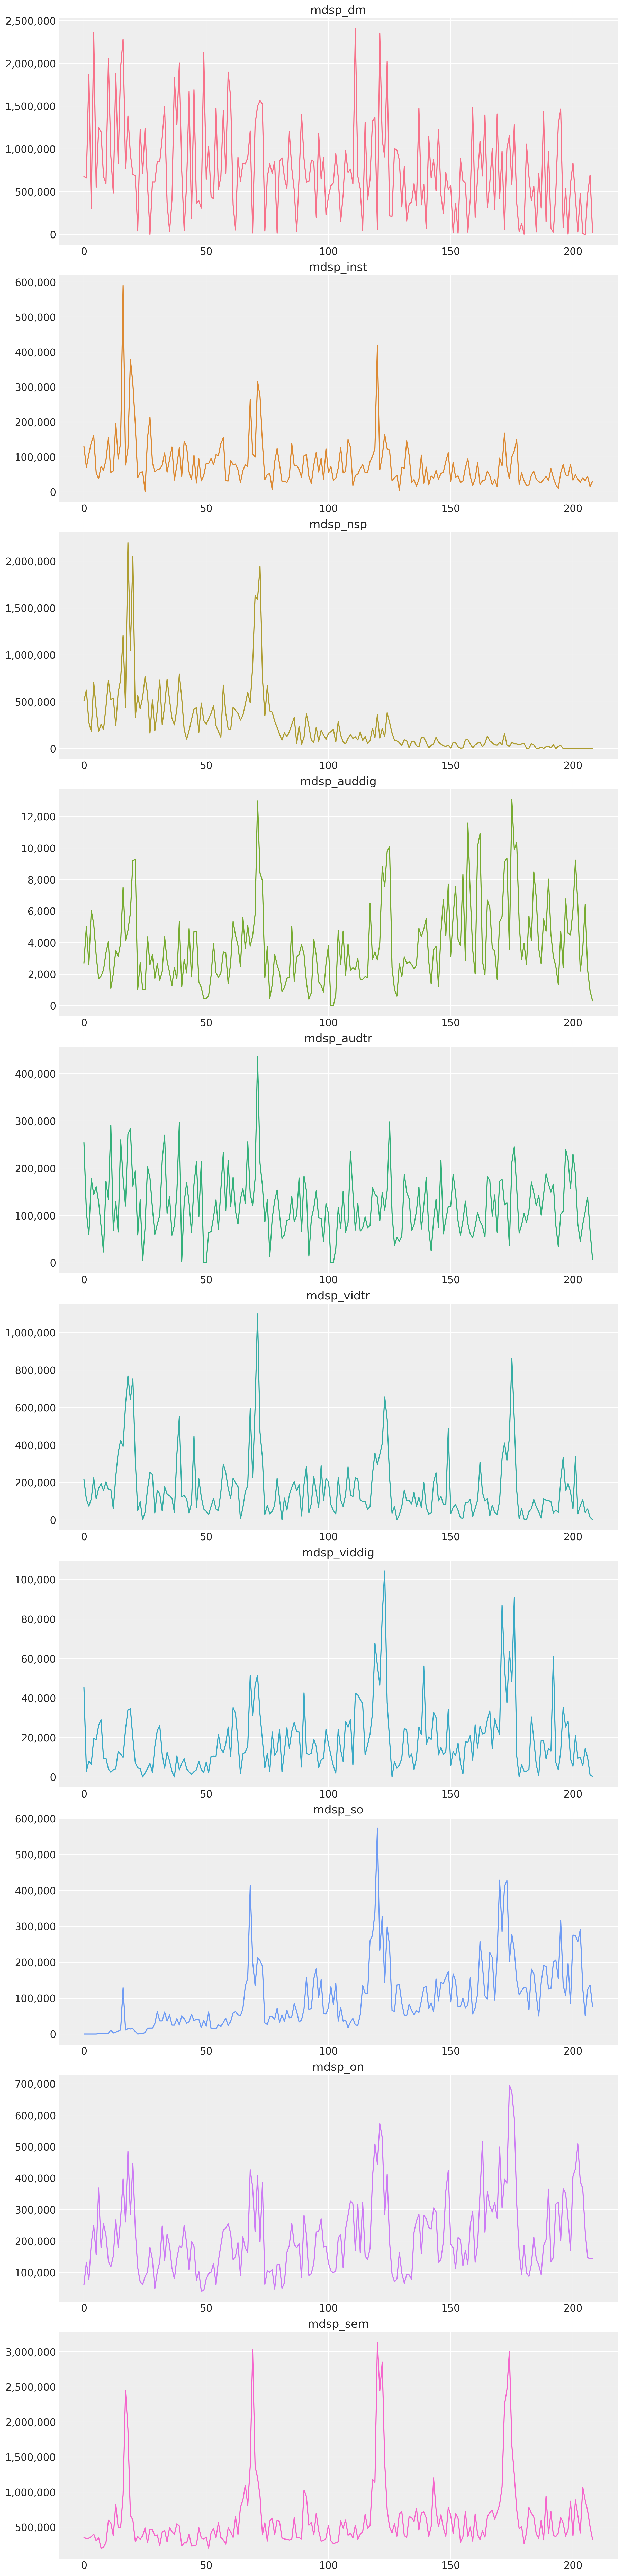

In [4]:
from matplotlib.ticker import FuncFormatter

# Create a color palette with the same number of colors as media channels
colors = sns.color_palette("husl", len(media_data.columns))

fig, ax = plt.subplots(nrows=len(media_data.columns), ncols=1, figsize=(12, 5 * len(media_data.columns)))
for i, col in enumerate(media_data.columns):
    ax[i].plot(media_data[col], color=colors[i])
    ax[i].set_title(col)

    # Format  y-axis tick labels with a comma separator
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

We can see some media channels with decreasing trends like `mdsp_dm`, `mdsp_inst`, or `mdsp_nsp`, while other has an increasing trends such as `mdsp_so` or `mdsp_on`. Another example of the variability across the different media channels is the stationality. We can see some media channels with clear patterns of stationality like `mdsp_so`, while others are more difficult to determine whether it has stationarity or not at a glance, like `mdsp_dm`.

Let's see how our sales data looks like.

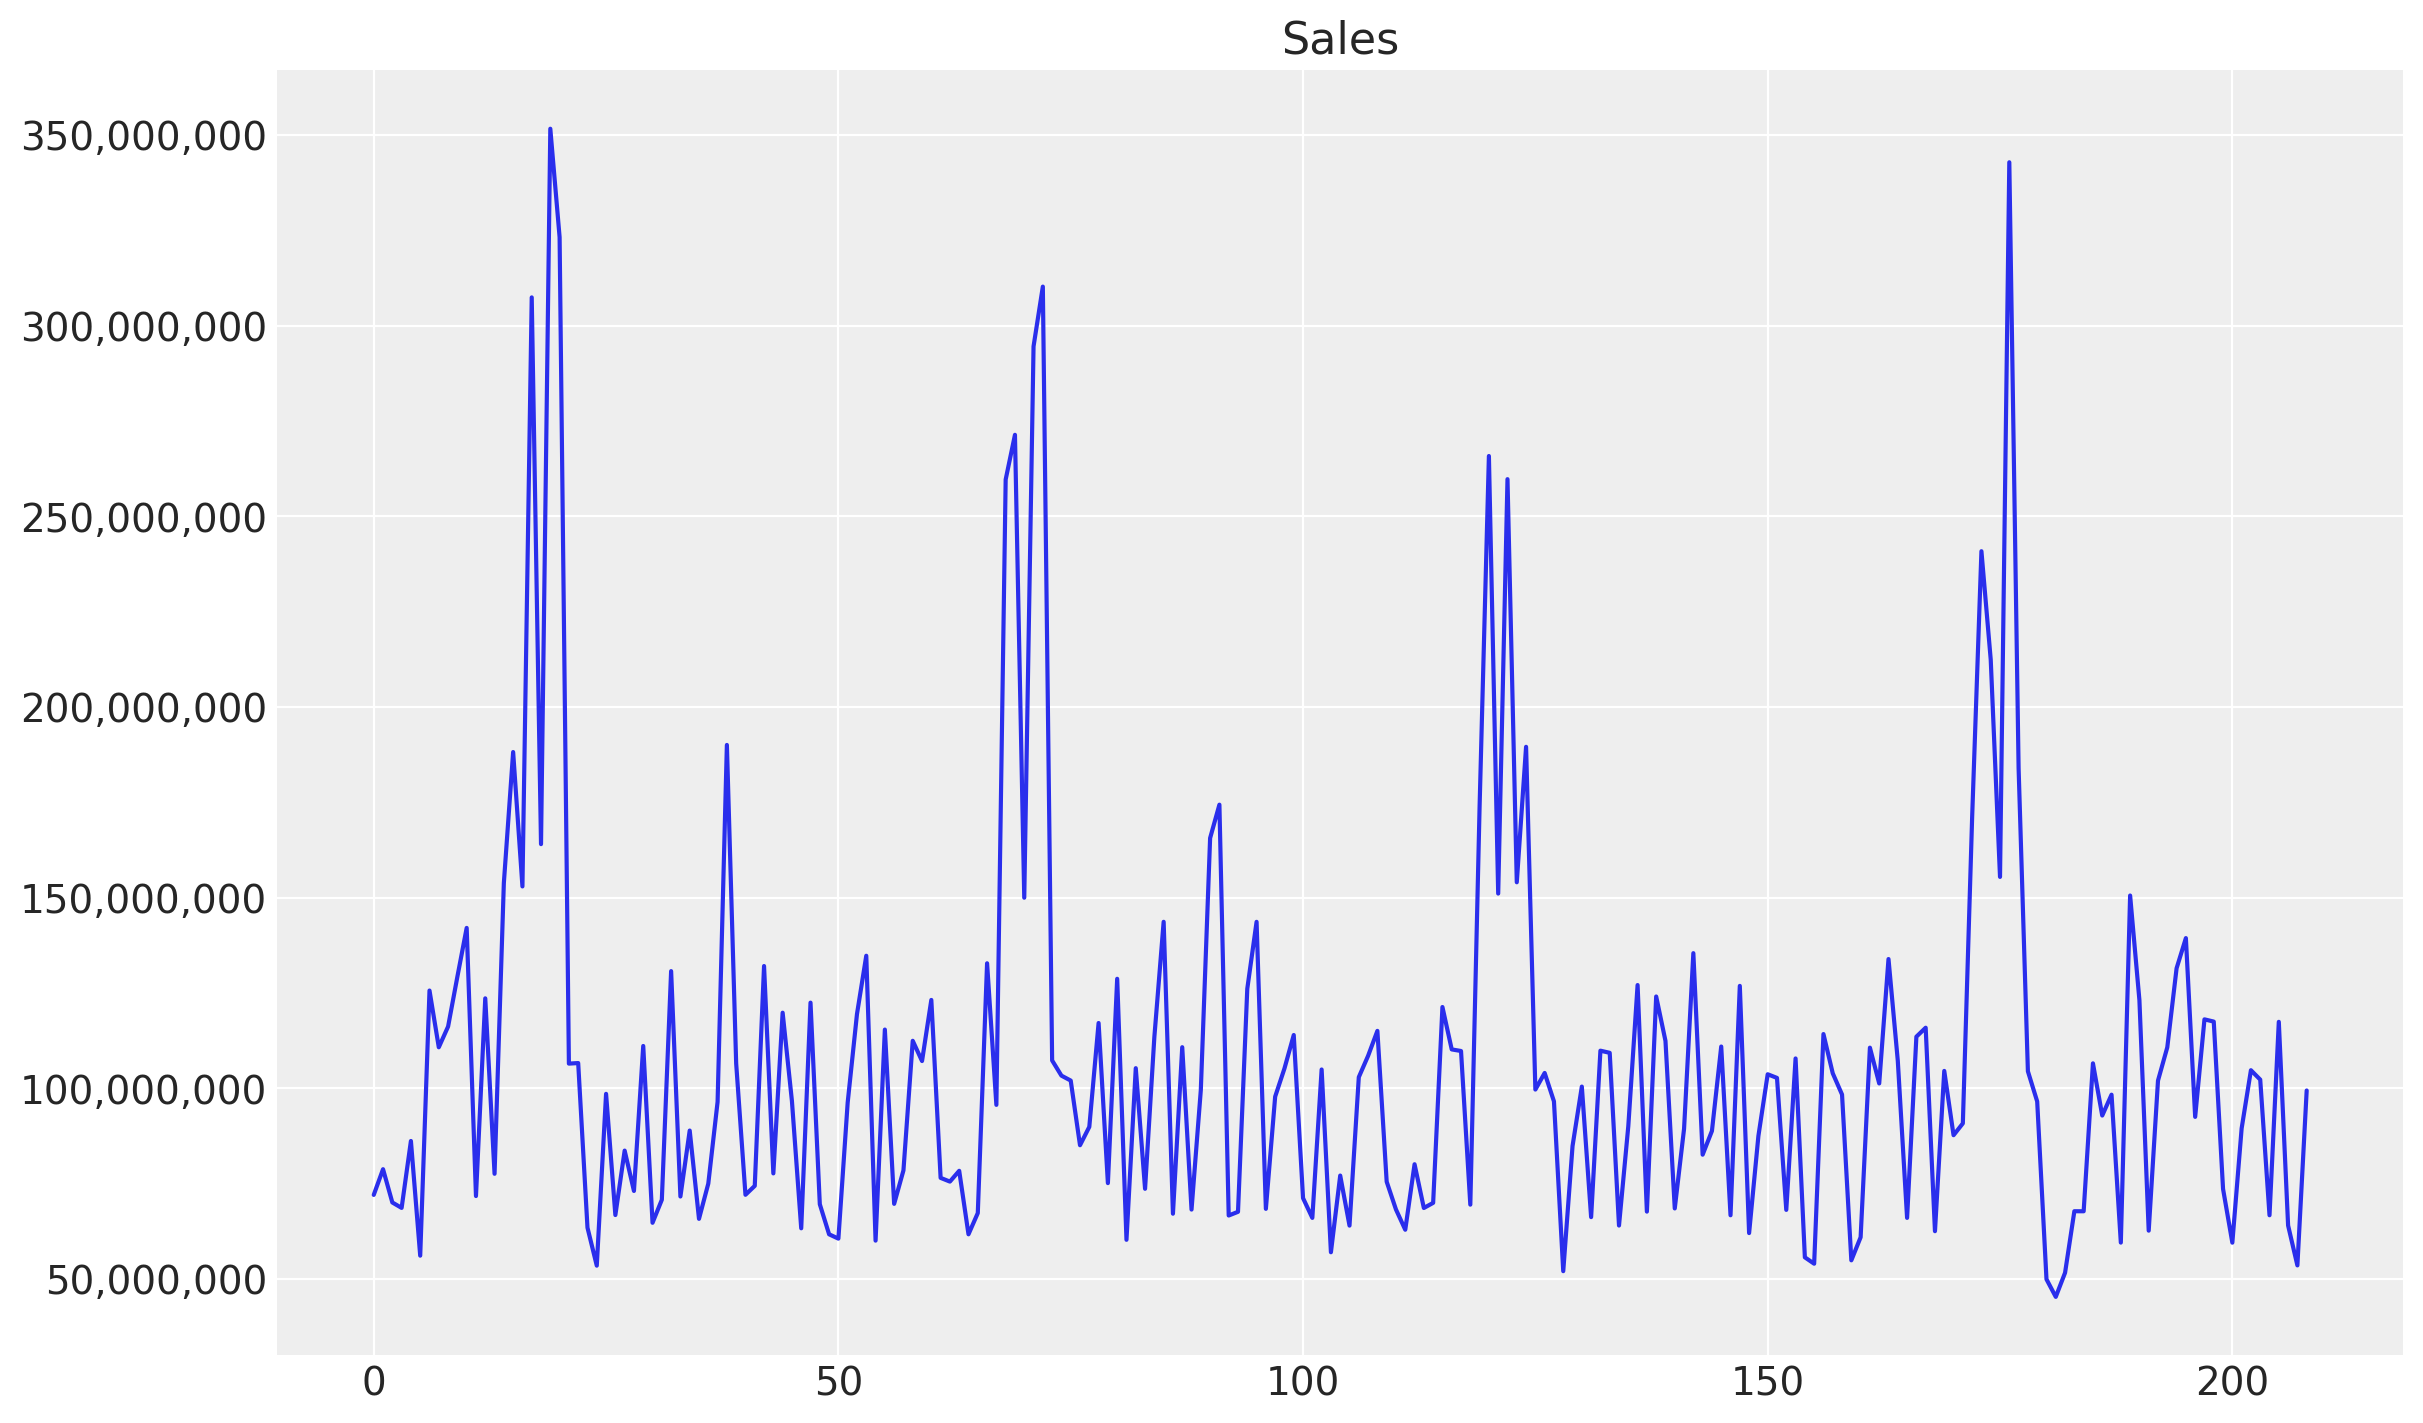

In [5]:
# Sales data
sales = data['sales']

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(sales)
ax.set_title('Sales')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

It seems that our sales data has also a stational component. Let's now preprocess our data.

## Preprocess data

We will split our data into train and test. Following the example carried out in [this article](https://towardsdatascience.com/media-mix-modeling-how-to-measure-the-effectiveness-of-advertising-with-python-lightweightmmm-b6d7de110ae6), we will leave only the last 24 weeks for testing.

In [6]:
final_data = data[['wk_strt_dt'] \
                  + media_columns \
                  + holiday_columns \
                  + seasonal_columns \
                  + ['sales']
                  ]

final_data.head()

wk_strt_dt     mdsp_dm  mdsp_inst   mdsp_nsp  mdsp_auddig  mdsp_audtr   
0  2014-08-03   678410.26  129759.66  507635.16      2700.69   254134.14  \
1  2014-08-10   661097.71   70355.33  625719.37      5039.35   106602.98   
2  2014-08-17  1874338.43  107720.37  277532.61      2610.93    59011.42   
3  2014-08-24   306583.37  141708.61  186028.61      6032.91   178010.46   
4  2014-08-31  2366274.16  160691.30  706694.09      5187.32   144097.56   

   mdsp_vidtr  mdsp_viddig  mdsp_so    mdsp_on  ...  seas_week_40   
0   216725.59     45397.90      0.0   61364.75  ...             0  \
1   108919.26      2903.36      0.0  132643.90  ...             0   
2    74032.19      8110.48      0.0   76741.27  ...             0   
3   110995.66      6516.22      0.0  193043.55  ...             0   
4   225140.84     19381.12      0.0  249612.89  ...             0   

   seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
0             0             0             0             0             0  \
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   seas_week_46  seas_week_47  seas_week_48        sales  
0             0             0             0  72051457.64  
1             0             0             0  78794770.54  
2             0             0             0  70071185.56  
3             0             0             0  68642464.59  
4             0             0             0  86190784.65  

[5 rows x 53 columns]

In [21]:
data_size = len(final_data)
n_test_data = 24
split_point = data_size - n_test_data

# Split into train and test
train = final_data.iloc[:split_point, :]
test = final_data.iloc[split_point:, :]

In [22]:
train.head()

wk_strt_dt     mdsp_dm  mdsp_inst   mdsp_nsp  mdsp_auddig  mdsp_audtr   
0  2014-08-03   678410.26  129759.66  507635.16      2700.69   254134.14  \
1  2014-08-10   661097.71   70355.33  625719.37      5039.35   106602.98   
2  2014-08-17  1874338.43  107720.37  277532.61      2610.93    59011.42   
3  2014-08-24   306583.37  141708.61  186028.61      6032.91   178010.46   
4  2014-08-31  2366274.16  160691.30  706694.09      5187.32   144097.56   

   mdsp_vidtr  mdsp_viddig  mdsp_so    mdsp_on  ...  seas_week_40   
0   216725.59     45397.90      0.0   61364.75  ...             0  \
1   108919.26      2903.36      0.0  132643.90  ...             0   
2    74032.19      8110.48      0.0   76741.27  ...             0   
3   110995.66      6516.22      0.0  193043.55  ...             0   
4   225140.84     19381.12      0.0  249612.89  ...             0   

   seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
0             0             0             0             0             0  \
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   seas_week_46  seas_week_47  seas_week_48        sales  
0             0             0             0  72051457.64  
1             0             0             0  78794770.54  
2             0             0             0  70071185.56  
3             0             0             0  68642464.59  
4             0             0             0  86190784.65  

[5 rows x 53 columns]

In [23]:
test.head()

wk_strt_dt     mdsp_dm  mdsp_inst  mdsp_nsp  mdsp_auddig  mdsp_audtr   
185  2018-02-18    29756.13   36218.37   1543.17      6840.17   120800.77  \
186  2018-02-25   713391.10   29165.72   2250.18      3617.07   142303.41   
187  2018-03-04   306953.51   26267.91  16895.99      2658.21   100587.52   
188  2018-03-11  1439848.44   35763.15   1020.83      5511.23   144140.62   
189  2018-03-18   149779.89   44218.65  20308.82      4725.60   188533.99   

     mdsp_vidtr  mdsp_viddig    mdsp_so    mdsp_on  ...  seas_week_40   
185    70139.68      6229.47  108425.88  142446.91  ...             0  \
186    42981.09       688.10   50121.84  123249.70  ...             0   
187     9223.92     18448.00  143463.91   93282.70  ...             0   
188   112888.06     18297.04  190657.74  185121.85  ...             0   
189   104671.48      9193.23  188403.37  204226.46  ...             0   

     seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
185             0             0             0             0             0  \
186             0             0             0             0             0   
187             0             0             0             0             0   
188             0             0             0             0             0   
189             0             0             0             0             0   

     seas_week_46  seas_week_47  seas_week_48         sales  
185             0             0             0  1.065449e+08  
186             0             0             0  9.285779e+07  
187             0             0             0  9.833291e+07  
188             0             0             0  5.954611e+07  
189             0             0             0  1.505493e+08  

[5 rows x 53 columns]

To scale our data, PyMC-Marketing provides its own `preprocessing` module. This module comes with different classes to preprocess the different kind of data that we are scaling, such as:

* `MaxAbsScaleChannels()`.
* `MaxAbsScaleTarget()`.
* `StandardizeControls()`.

In [24]:
# Scale media
media_scaler = MaxAbsScaleChannels()
media_scaler.channel_columns = media_columns
scaled_train = media_scaler.max_abs_scale_channel_data(train)
scaled_test = media_scaler.max_abs_scale_channel_data(test)

# Scale target
target_scaler = MaxAbsScaleTarget()
target_scaler.target_column = 'sales'
scaled_train = media_scaler.max_abs_scale_channel_data(scaled_train)
scaled_test = media_scaler.max_abs_scale_channel_data(scaled_test)

In [25]:
scaled_train.head()

wk_strt_dt   mdsp_dm  mdsp_inst  mdsp_nsp  mdsp_auddig  mdsp_audtr   
0  2014-08-03  0.281510   0.219876  0.230904     0.206715    0.583392  \
1  2014-08-10  0.274326   0.119216  0.284616     0.385719    0.244719   
2  2014-08-17  0.777767   0.182531  0.126239     0.199844    0.135467   
3  2014-08-24  0.127219   0.240124  0.084617     0.461767    0.408642   
4  2014-08-31  0.981899   0.272290  0.321449     0.397045    0.330791   

   mdsp_vidtr  mdsp_viddig  mdsp_so   mdsp_on  ...  seas_week_40   
0    0.197008     0.435044      0.0  0.088199  ...             0  \
1    0.099010     0.027823      0.0  0.190649  ...             0   
2    0.067297     0.077722      0.0  0.110300  ...             0   
3    0.100897     0.062444      0.0  0.277461  ...             0   
4    0.204658     0.185728      0.0  0.358768  ...             0   

   seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
0             0             0             0             0             0  \
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   seas_week_46  seas_week_47  seas_week_48        sales  
0             0             0             0  72051457.64  
1             0             0             0  78794770.54  
2             0             0             0  70071185.56  
3             0             0             0  68642464.59  
4             0             0             0  86190784.65  

[5 rows x 53 columns]

In [26]:
scaled_test.head()

wk_strt_dt   mdsp_dm  mdsp_inst  mdsp_nsp  mdsp_auddig  mdsp_audtr   
185  2018-02-18  0.020290   0.459203  0.036726     0.741103    0.503454  \
186  2018-02-25  0.486448   0.369784  0.053552     0.391894    0.593069   
187  2018-03-04  0.209306   0.333043  0.402109     0.288006    0.419213   
188  2018-03-11  0.981805   0.453431  0.024295     0.597118    0.600726   
189  2018-03-18  0.102132   0.560636  0.483331     0.511999    0.785742   

     mdsp_vidtr  mdsp_viddig   mdsp_so   mdsp_on  ...  seas_week_40   
185    0.208414     0.102051  0.342296  0.280095  ...             0  \
186    0.127714     0.011272  0.158233  0.242347  ...             0   
187    0.027408     0.302213  0.452910  0.183423  ...             0   
188    0.335436     0.299740  0.601899  0.364007  ...             0   
189    0.311022     0.150603  0.594782  0.401572  ...             0   

     seas_week_41  seas_week_42  seas_week_43  seas_week_44  seas_week_45   
185             0             0             0             0             0  \
186             0             0             0             0             0   
187             0             0             0             0             0   
188             0             0             0             0             0   
189             0             0             0             0             0   

     seas_week_46  seas_week_47  seas_week_48         sales  
185             0             0             0  1.065449e+08  
186             0             0             0  9.285779e+07  
187             0             0             0  9.833291e+07  
188             0             0             0  5.954611e+07  
189             0             0             0  1.505493e+08  

[5 rows x 53 columns]

## Model fitting<a name="model_fitting"></a>

Now that we have our data preprocessed, we will use the `DelayedSaturatedMMM` class to define the model

In [37]:
mmm = DelayedSaturatedMMM(
    data=scaled_train,
    target_column='sales',
    date_column='wk_strt_dt',
    channel_columns=media_columns,
    control_columns=holiday_columns + seasonal_columns,
    adstock_max_lag=8,
    yearly_seasonality=None
)

You can access the model as `mmm.model` and see the explicit model structure with the function `model_to_graphviz` (you might need to install `graphviz` first if you haven't installed it yet).

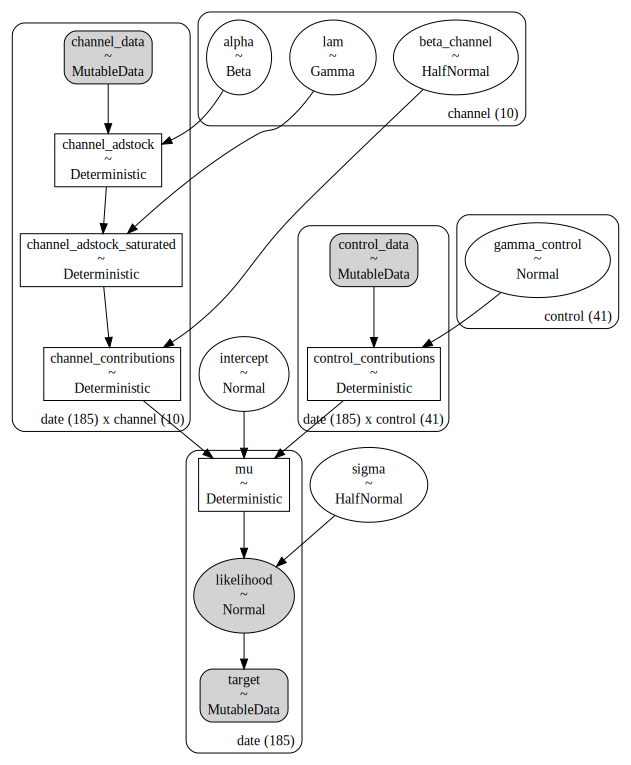

In [38]:
pm.model_to_graphviz(model=mmm.model)

We can now fit the model:

In [39]:
SEED = 0

mmm.fit(target_accept=0.95, chains=10, random_seed=SEED)

## Model Diagnostics<a name="model_diagnostics"></a>

In [40]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [46]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "sigma",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean   
intercept                    0.116  0.460  -0.740    0.990      0.016  \
beta_channel[mdsp_dm]        0.108  0.159   0.000    0.301      0.002   
beta_channel[mdsp_inst]      0.250  0.282   0.000    0.671      0.003   
beta_channel[mdsp_nsp]       0.168  0.222   0.000    0.479      0.003   
beta_channel[mdsp_auddig]    0.065  0.121   0.000    0.206      0.001   
...                            ...    ...     ...      ...        ...   
gamma_control[seas_week_45] -0.089  0.465  -0.991    0.771      0.016   
gamma_control[seas_week_46]  0.387  0.468  -0.451    1.305      0.016   
gamma_control[seas_week_47]  0.252  0.466  -0.643    1.125      0.016   
gamma_control[seas_week_48] -0.097  0.464  -0.972    0.773      0.016   
sigma                        0.091  0.006   0.081    0.102      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                      0.011     865.0    1707.0   1.01  
beta_channel[mdsp_dm]          0.001    7619.0    5699.0   1.00  
beta_channel[mdsp_inst]        0.002    8176.0    5631.0   1.00  
beta_channel[mdsp_nsp]         0.002    7394.0    5393.0   1.00  
beta_channel[mdsp_auddig]      0.001    8842.0    6358.0   1.00  
...                              ...       ...       ...    ...  
gamma_control[seas_week_45]    0.011     869.0    1733.0   1.01  
gamma_control[seas_week_46]    0.011     907.0    1768.0   1.01  
gamma_control[seas_week_47]    0.011     891.0    1818.0   1.01  
gamma_control[seas_week_48]    0.011     882.0    1763.0   1.01  
sigma                          0.000   12791.0    7359.0   1.00  

[73 rows x 9 columns]

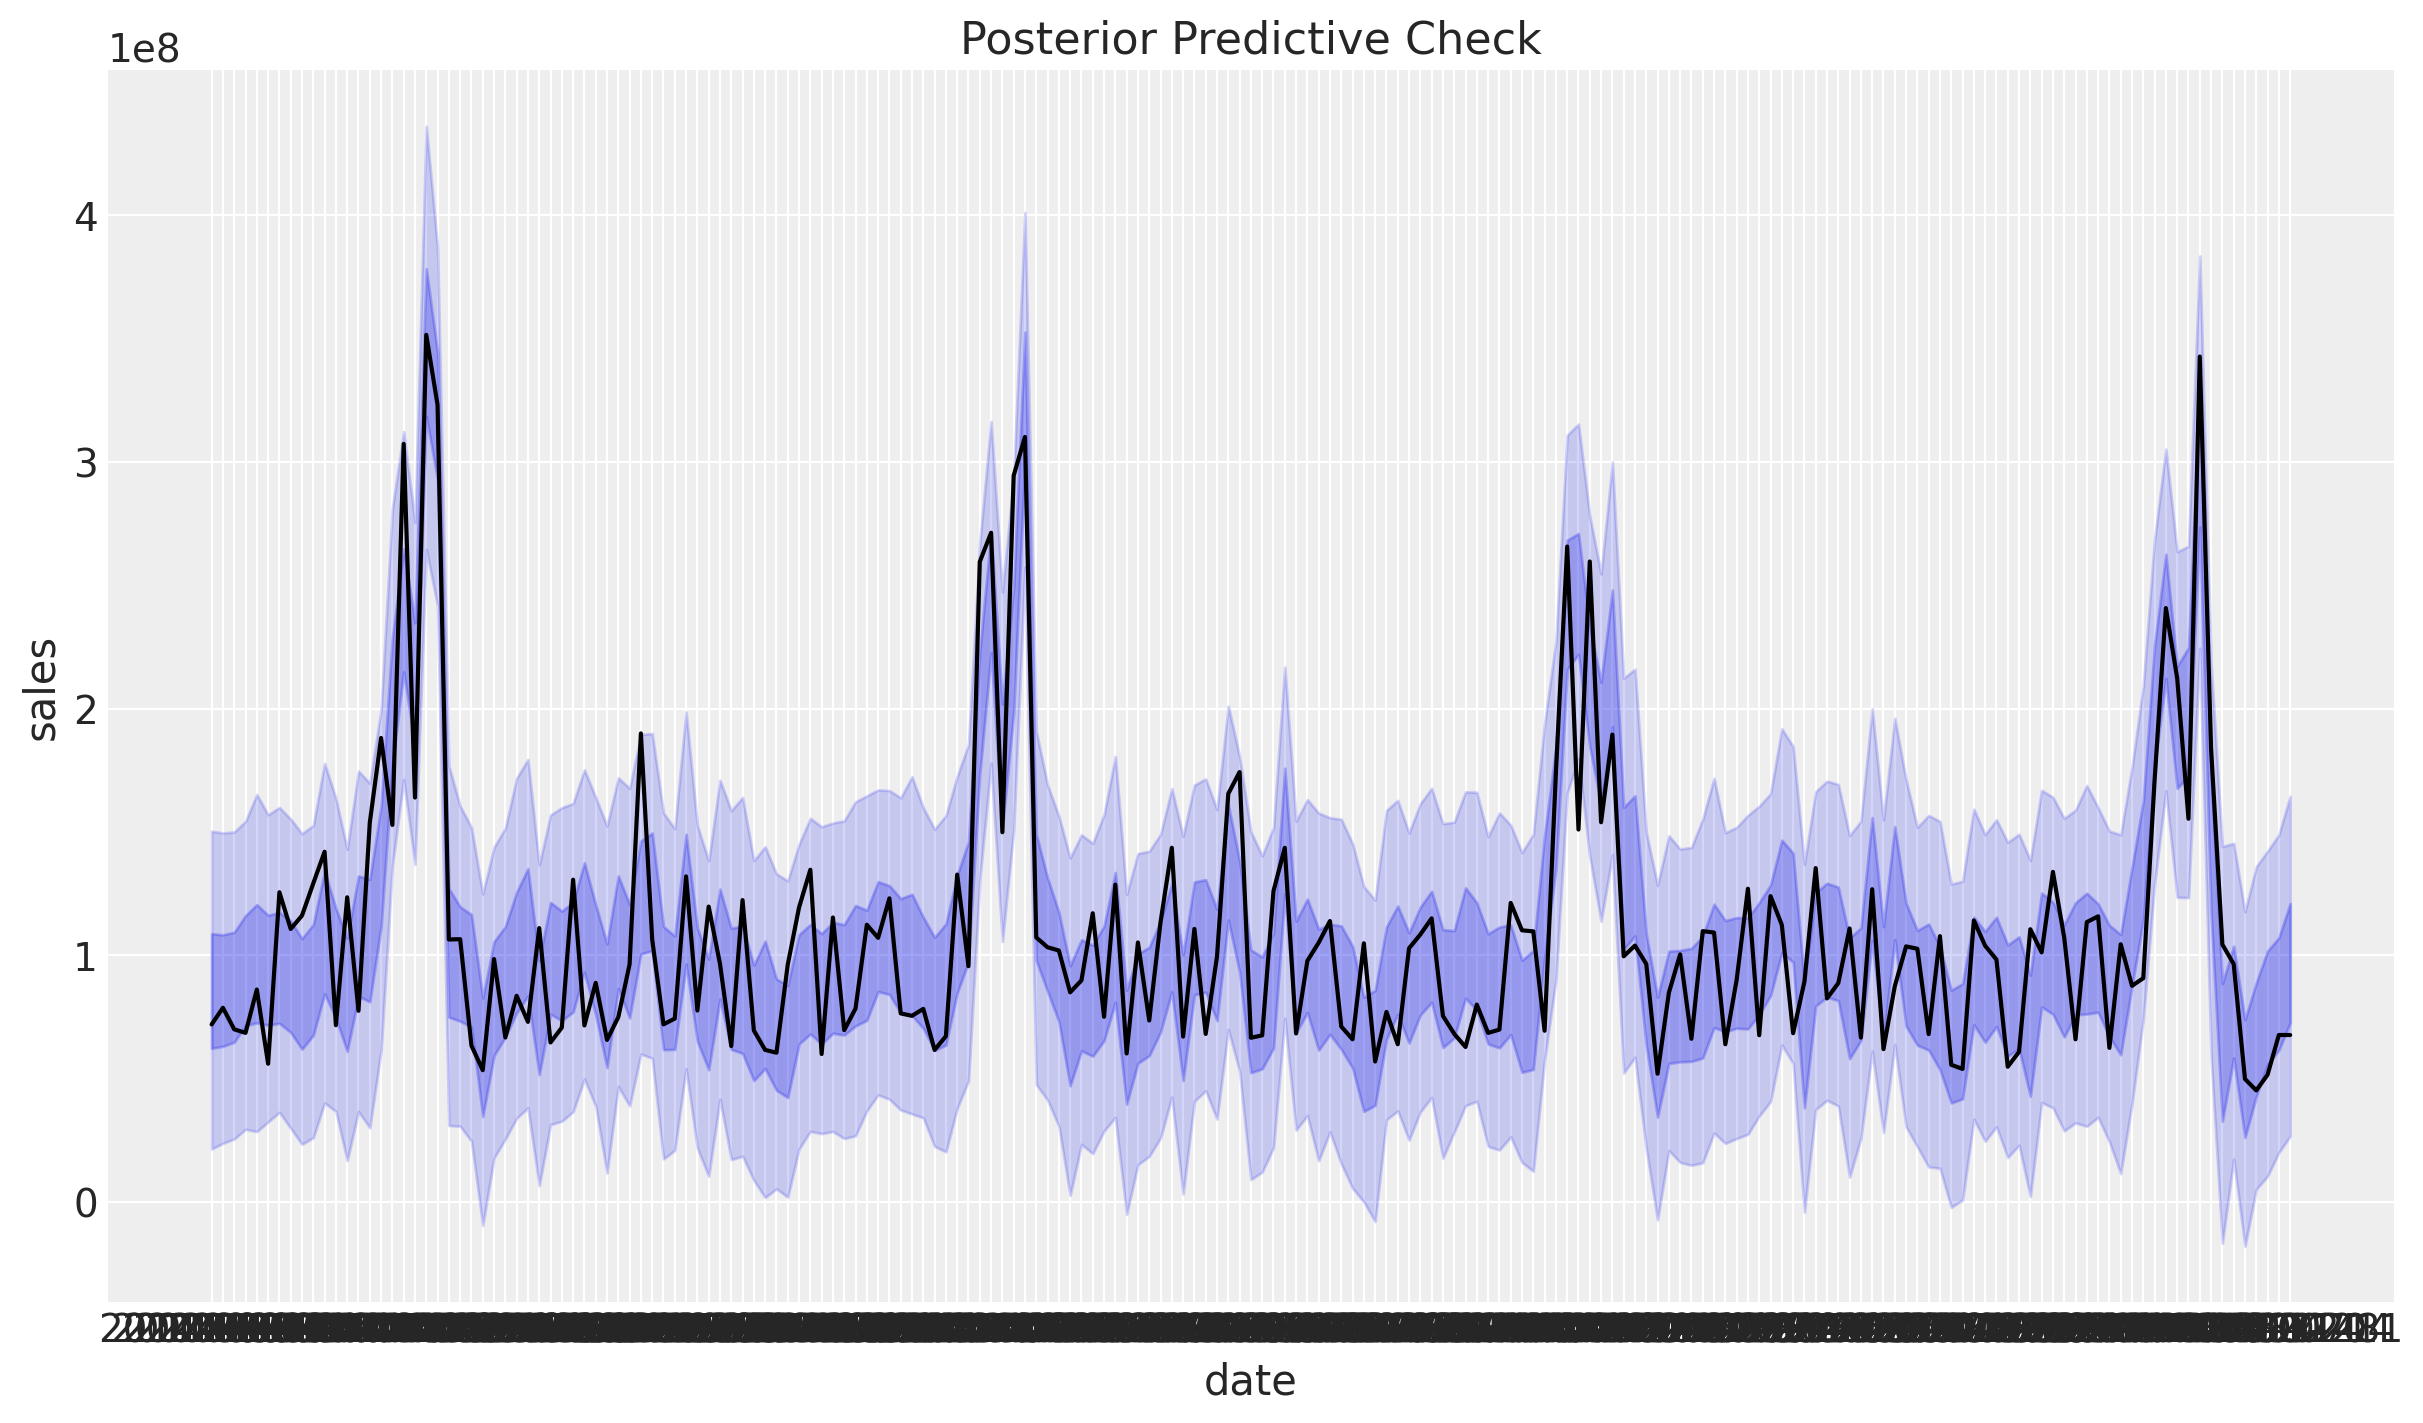

In [42]:
mmm.plot_posterior_predictive(original_scale=True);

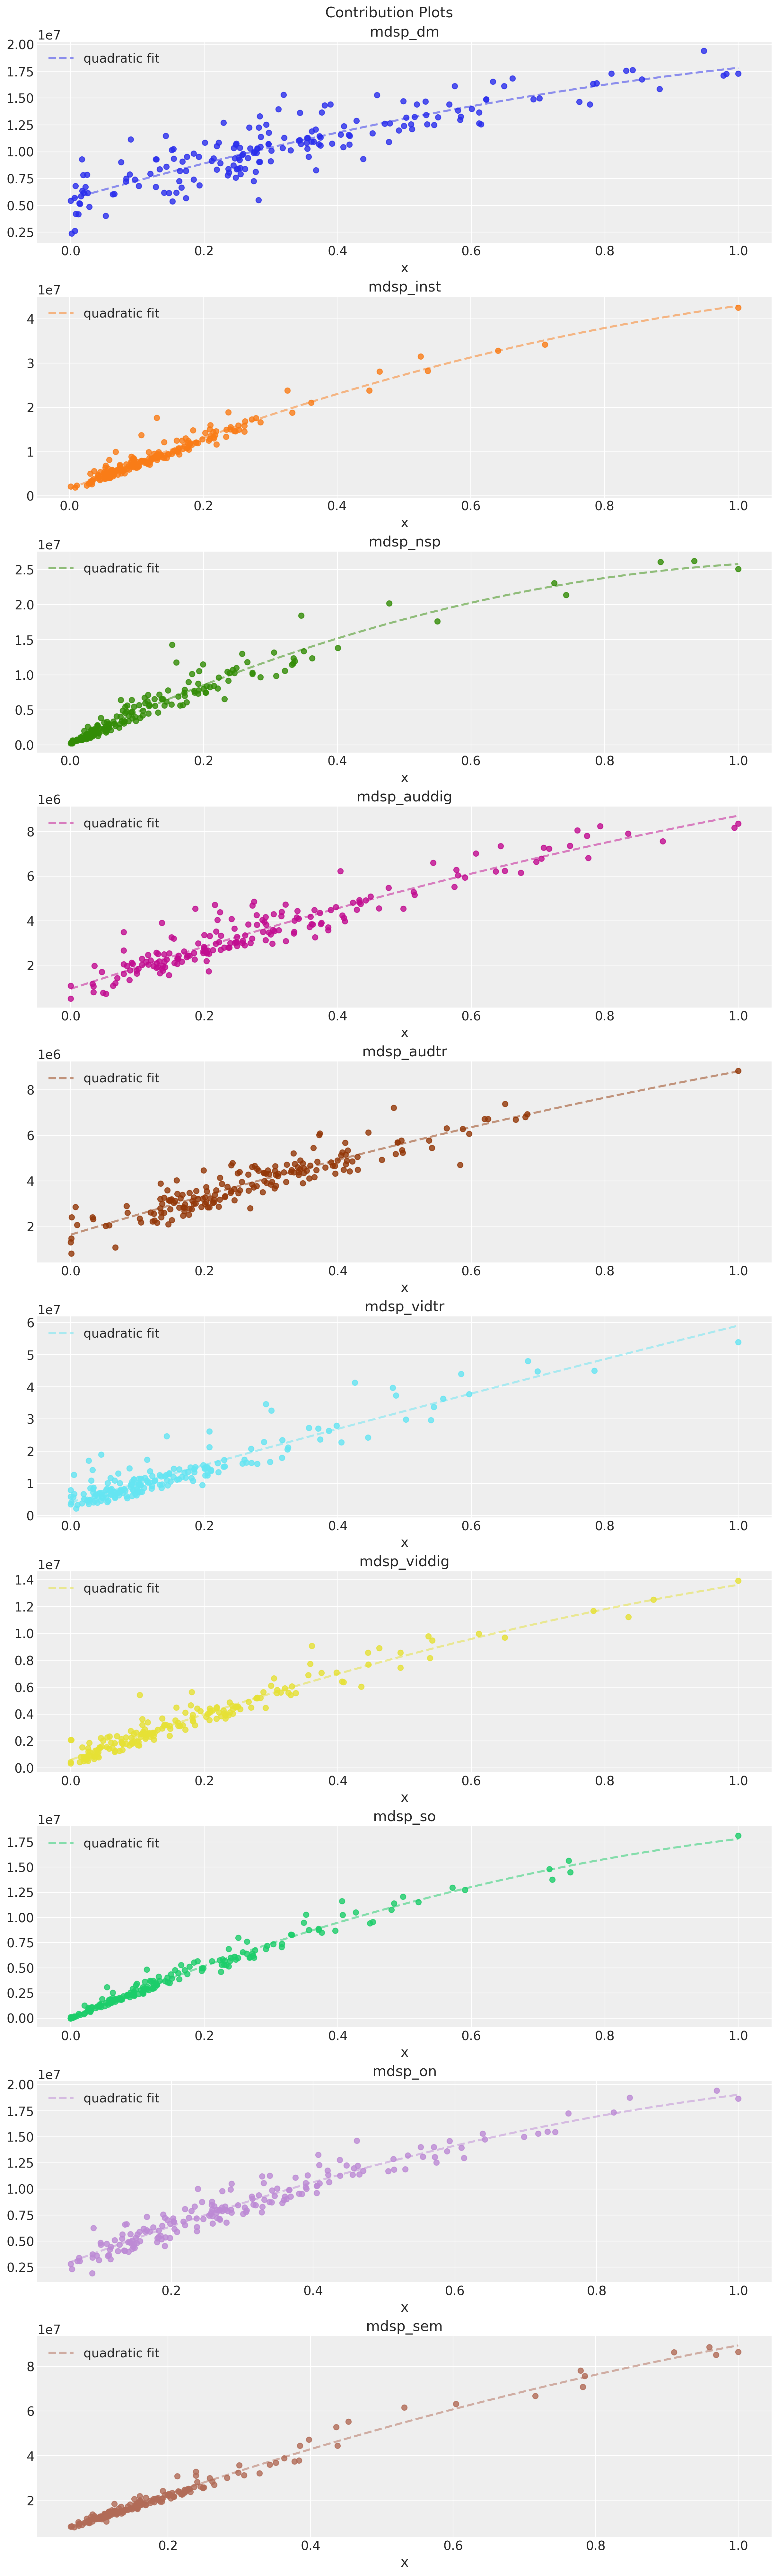

In [44]:
fig = mmm.plot_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];